# IE 535 Final Project
Nakul Upadhya (PUID: 0030968801)

In this project, we create a solver for linear programs that utilizes the two-phased simplex method. This document then runs through some very basic cases to prove that it can handle various things like degeneracy, unboundedness, and infeasibility. After this, a few models are formulated and solved using this `SimplexSolver.` 

Many of our test cases are from the textbook *Linear Programming and Network Flows, 4th edition* [1] AKA the BJS Book. Our Test cases are: 

* Standard form problem (BJS Book)
* No Identity Starting Basis (BJS Book)
* Some Variables Negative
* Unbounded Problem (BJS Book)
* Infeasible Problem (BJS Book)
* Degenerate Problem (BJS Book)
* Redundant Constraints Problem (BJS Book)


The models we are solving are all from the MATH 407 course from the University of Washington [2]. The ones solved using `SimplexSolver` are:
* Model 9: Investments over Time
* Model 12: Alloys
* Model 11: A Packing Problem

The outputs and solutions from `SimplexSolver` are then compared with the outputs from an existing commercial convex optimization solver: [CVXPY](https://www.cvxpy.org/) [3]. 

**Citations:**

[1] Bazaraa, M. S., John J. Jarvis, and Hanif D. Sherali. Linear Programming and Network Flows . Fourth edition. Hoboken, New Jersey: Wiley, 2010. Print.

[2] Professor James Burke's MATH 407 Course Website. [https://sites.math.washington.edu/~burke/crs/407/models/index.html](https://sites.math.washington.edu/~burke/crs/407/models/index.html)

[3] Diamond, S., & Boyd, S. (2016). CVXPY: A Python-embedded modeling language for convex optimization. The Journal of Machine Learning Research, 17(1), 2909-2913.

## General Simplex Solver
### Description
This program accepts a few inputs: 
* `c` is the coefficients for your objective function
* `A` is the matrix that represents the coefficients for your variables in the constraints (non-negativity not included)
* `b` is the values for your constraints 
* `signs` the relationship between each row of the `A` and its respective entry in `b`
* `maximize` is a boolean value that indicates whether the problem supplied is a maximization problem or not (by default this is `False`
* `free` is an array of booleans indicating which if any variables are free/unrestricted (not bound by negativity or non-negativity constraints). By default, this is `None` indicating that no variables are free variables
* `neg` is an array of booleans indicating if any variables are bound by negativity constraints instead of non-negativity constraints ($x_i \leq 0$ instead of $x_i \geq 0$). By default, this is `None` indicating that all variables are bound by the non-negativity constraint
* `verbose` is a boolean indicating whether or not the solver should print its process to the console. By default this is `True`
* `precision` controls the number of decimals outputted by the print statements. This defaults to 5

The non-negativity constraints ($x \geq 0 $) should not be included in the `A` and `b` variables. If a variable is less than a non-zero negative number ($x\leq \mathbb{R}^-$), its flag in `neg` must be `True` and the constraint must be included in the `A` and `b` variables.

To solve your problem, first instantiate the class. Then run `SimplexSolver.solve()`. For example:

```
a = SimplexSolver(c,A,b,["<=", "<="], maximize = True)
a.solve()
```

`SimplexSolver.solve()` returns a tuple with 3 values: your optimal solution, the optimal value, and a direction. If the problem is finite, the direction will always be a zero vector, otherwise it will be filled with values. 
### Simplex Solver Code

In [231]:
import numpy as np
class SimplexSolver:
    def __init__(self, c, A, b, signs, maximize = False, free = None, neg = None, verbose = True, precision = None):
        np.set_printoptions(suppress=True)
        self.verbose = verbose
        if type(A) == list:
            A = np.array(A)
        if type(c) == list:
            c = np.array(c)
        if type(b) == list:
            b = np.array(b)
        if type(signs) == list:
            signs = np.array(signs)
        if c.shape[0] != A.shape[1] or c.ndim != 1:
            raise ValueError("Shape of objective function (c) does not match shape of constraint system (A)")
        if b.shape[0] != A.shape[0] or b.ndim != 1:
            raise ValueError("Shape of constraint values (b) does not match shape of constraint system (A)")
        if b.shape[0] != signs.shape[0] or signs.ndim != 1:
            raise ValueError("Shape of signs array (signs) does not match shape of of constraint values (b)")
        n_var = c.shape[0]
        n_constraint = A.shape[0]
        if free != None:
            if type(free) == list:
                free = np.array(free)
                free = free.astype(bool)
            else:
                free = np.zeros(n_var).astype(bool)
            if free.shape[0] != n_var or free.ndim != 1:
                raise ValueError("Shape of free variables (free) does not match shape of Constraint system (A)")
        if neg != None: 
            if type(neg) == list:
                neg = np.array(neg)
                neg = neg.astype(bool)
            else:
                neg = np.zeros(n_var).astype(bool)
            if neg.shape[0] != n_var or neg.ndim != 1:
                raise ValueError("Shape of negative variables (free) does not match shape of Constraint system (A)")
        if neg is not None and free is not None:
            for i in range(n_var):
                if neg[i] and free[i]:
                    exception = "X"+str(i+1) +" cannot be free and <= 0 at the same time"
                    raise ValueError(exception)
        if maximize:
            c *= -1
        original_dict = {
            'A':A,
            'c':c,
            'b':b,
            'signs':signs,
            'n_var':n_var,
            'n_constraint':n_constraint,
            'free':free,
            'neg':neg,
            'maximize':maximize
        }
        if precision is None:
            self.display_round = 5
            self.round = None
            self.precision = False
        else:
            self.display_round = precision
            self.round = precision
            self.precision = True
        #self.precision = precision
        
        self.original_parameters = original_dict
        self.free_pair =[]
        self.A = A
        self.c = c
        self.b = b
        self.neg = neg
        self.free = free
        self.signs = signs
        self.tableau = None
        self.n_var = n_var
        self.n_constraint = n_constraint
        self.x = np.empty(n_var)
        self.x[:] = np.nan
        self.maximize = maximize
        self.objective_value = np.nan
        print("Solver object created with " + str(n_var) + " variables and " + str(n_constraint) + " constraints.")
    def solve(self):
        self.fix_neg()
        self.fix_free()
        self.add_slack()
        self.fix_constraint_values()
        self.phase1()
        return self.phase2()
        #self.decrypt_tableau()
        #return self.x, self.objective_value
    def fix_neg(self):
        if self.neg is None:
            return
        for i in range(len(self.neg)):
            if self.neg[i]:
                self.c[i] *= -1
                self.A[:,i] *= -1
    def fix_free(self):
        if self.free is None:
            return
        free_additions = []
        if np.sum(self.free) == 0:
            return
        for i in range(len(self.free)):
            if self.free[i]:
                A_temp = self.A[:,i].copy() 
                c_temp = self.c[i].copy()
                A_temp *= -1
                c_temp *= -1
                free_additions.append([i+1, A_temp, c_temp])
        for add in reversed(free_additions):       
            self.A = np.insert(self.A, add[0], add[1], axis = 1)
            self.c = np.insert(self.c, add[0], add[2])
            self.free_pair.append((add[0], add[0]-1))
            self.n_var += 1
    def add_slack(self):
        num_slack = 0
        for i in range(len(self.signs)):
            sign = signs[i]
            if sign == ">=":
                temp = np.zeros(self.n_constraint)
                temp[i] = -1
                self.A = np.insert(self.A, self.A.shape[1], temp, axis = 1)
                self.c = np.insert(self.c, self.c.shape[0], 0)
                num_slack += 1
            if sign == "<=":
                temp = np.zeros(self.n_constraint)
                temp[i] = 1
                self.A = np.insert(self.A, self.A.shape[1], temp, axis = 1)
                self.c = np.insert(self.c, self.c.shape[0], 0)
                num_slack += 1
        self.num_slack = num_slack
        if self.verbose:
            print(str(num_slack) + " slack variables added.")
    def fix_constraint_values(self):
        for i in range(len(self.b)):
            if self.b[i] < 0:
                self.b[i] *= -1
                self.A[i,:] *= -1
    def phase1(self):
        self.phase1counter = 0
        self.construct_phase1_tableau()
        self.fix_initial_p1_tableau()
        optimal = self.check_optimality()
        #direction = self.check_direction()
        while not optimal:
            self.simplex_iterator()
            optimal = self.check_optimality()
        ###### FEASIBILITY CHECK #############
        self.feasibility_check()
        ######################################
        if self.verbose:
            print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
            print("Phase 1 Completed!")
        ########### REDUNDANCY CHECK #########
        if np.any(self.basis >= self.real_variable_border):
            for i in reversed(range(len(self.basis))):
                if self.basis[i] >= self.real_variable_border:
                    if self.verbose:
                        print("Constraint number " + str(i+1) + " is redundant")
                    ########## Removing redundant constraints ########
                    self.basis = np.delete(self.basis, i)
                    self.tableau = np.delete(self.tableau, i+1, axis = 0)
        #######################################
        for i in reversed(range(self.real_variable_border, self.tableau.shape[1]-1)):
            self.tableau = np.delete(self.tableau, i, axis = 1)
    def feasibility_check(self):
        temp = np.round(self.tableau[0,-1],8)
        if temp != 0:
            raise ValueError("The given problem is infeasible.")
    def construct_phase1_tableau(self):
        tempA = self.A.copy()
        i = np.identity(self.A.shape[0])
        self.real_variable_border = tempA.shape[1]
        tableau = np.concatenate([tempA, i], axis = 1)
        tableau = np.insert(tableau, tableau.shape[1], self.b.copy(), axis = 1)
        top_row = np.zeros(tableau.shape[1])
        basis = []
        for i in reversed(range(tableau.shape[0])):
            index = top_row.shape[0] - 2 - i
            top_row[index] = -1
            basis.append(index)
        tableau = np.vstack([top_row, tableau])
        self.tableau = tableau
        if self.verbose:
            print("Begin Phase 1 with " + str(self.n_constraint) + " artificial variables.")
            print("Step Zero Phase 1 Tableau: ")
            print(self.tableau)
            print("Basis Columns:")
            print(basis)
        self.basis = np.array(basis)
    def fix_initial_p1_tableau(self):
        for i in range(1, self.tableau.shape[0]):
            self.tableau[0,:] += self.tableau[i,:]
        if self.verbose:
            print("Step 1 Phase 1 Tableau. Current RHS = " + str(self.tableau[0, -1]))
            print(self.tableau)
            print("Starting Phase 1:")
    def check_optimality(self):
        temp = self.tableau[0,0:self.tableau.shape[1] - 1].copy()
        temp = np.round(temp, 8)
        return np.all(temp <= 0)
    def simplex_iterator(self):
        ########## BLANDS RULE PART 1 ####################
        if np.any(self.tableau[1:,-1] == 0):
            for i in range(len(self.tableau[0,:self.tableau.shape[1]-1])):
                if i not in self.basis and self.tableau[0,i] > 0:
                    entering = i
                    break
        else:
            cur_max = float("-inf")
            entering = 0
            for i in range(len(self.tableau[0,:self.tableau.shape[1]-1])):
                if i not in self.basis and self.tableau[0,i] > 0 and self.tableau[0,i] > cur_max:
                    cur_max = self.tableau[0,i]
                    entering = i
        entering_col = self.tableau[1:,entering]
        
        ######## CHECKING FOR DIRECTIONS/ UNBOUNDEDNESS ########
        if np.all(self.tableau[1:,entering] <= 0):
                self.unbounded = True
                self.unbounded_index = entering
                return
        ######## BLANDS RULE PART 2 ############################
        pivot_row = 0
        ratio = float("inf")

        for i in range(len(self.tableau[1:,entering])):
            if not self.tableau[i+1,entering] <= 0:
                new = self.tableau[i+1,-1] / self.tableau[i+1,entering]
                if new < ratio:
                    pivot_row = i
                    ratio = new
        pivot_row += 1
        if self.verbose:
            print("--------------------------------------------------")
            print("Pivot Row= " + str(pivot_row))
            print("Leaving Variable = " + str(self.basis[pivot_row - 1]) + ", Entering Variable = " + str(entering))
        self.basis[pivot_row - 1] = entering
        
        for i in range(self.tableau.shape[0]):
            if i != pivot_row:
                self.tableau[i,:] += -1*self.tableau[i,entering] / self.tableau[pivot_row,entering]*self.tableau[pivot_row,:]
        self.tableau[pivot_row,:] = self.tableau[pivot_row,:] / self.tableau[pivot_row, entering]
        if self.verbose:
            print("Basis: " + str(self.basis))
            print("tableau: ")
            print(np.round(self.tableau, 2))
            print("RHS: ", np.round(self.tableau[0,-1], 5))
    def check_unbounded(self, entering = None):
        top_row = self.tableau[0,:].copy()
        top_row = top_row[0:len(top_row)-1]
        last_col = self.tableau[:,-1].copy()
        last_col = last_col[1:]
        if entering is None:
            if np.any(last_col == 0):
                entering = np.argmax(top_row>0)
            else:
                entering = top_row.argmax()
        entering_col = self.tableau[1:,entering].copy()
        entering_col = np.round(entering_col, 8)
        ##Check for Directions
        if np.all(entering_col <= 0):
            self.unbounded = True
            self.unbounded_index = entering
            return True
        else:
            return False
    def phase2(self):
        top_row = np.insert(-1*self.c.copy(), self.c.shape[0],0)
        self.tableau[0,:] = top_row
        temp = []
        for i in self.basis:
            temp.append(int(i))
        self.basis = temp
        if self.verbose:
            print("Begin Phase 2! Current Tableau is: ")
            print(self.tableau)
            print("Current Basis is: ")
            print(self.basis)
        for i in range(len(self.basis)):
            col = self.basis[i]
            self.tableau[0,:] += -1*self.tableau[0,col]*self.tableau[i+1,:]
        if self.verbose:
            print("Adjusted Tableau: ")
            print(self.tableau)
        optimal = self.check_optimality()
        unbounded = self.check_unbounded()
        while not optimal and not unbounded:
            self.simplex_iterator()
            optimal = self.check_optimality()
            unbounded = self.check_unbounded()
        ###### Handling Termination Conditions
        if unbounded:
            return self.create_unbounded_solution()
        if optimal:
            return self.create_bounded_solution()
    def create_unbounded_solution(self):
        top_row = self.tableau[0,:].copy()
        top_row = top_row[0:len(top_row)-1]
        last_col = self.tableau[:,-1].copy()
        last_col = last_col[1:]
        if np.any(last_col == 0):
            entering = np.argmax(top_row>0)
        else:
            entering = top_row.argmax()
        entering_col = self.tableau[1:,entering].copy()
        solution = np.zeros(self.n_var + self.num_slack)
        direction = np.zeros(self.n_var + self.num_slack)
        for i in range(len(self.basis)):
            solution[self.basis[i]] = last_col[i]
            direction[self.basis[i]] = -1* entering_col[i]
        direction[entering] = 1
        if self.maximize:
            val = float("inf")
        else:
            val = float("-inf")
        direction = direction[:len(direction)-self.num_slack]
        solution = solution[:len(solution)-self.num_slack]
        for extra,original in self.free_pair:
            solution[original] = solution[original]-solution[extra]
            solution = np.delete(solution, extra)
            direction[original] = direction[original]-direction[extra]
            direction = np.delete(direction, extra)
        if np.any(np.array(self.neg)):
            for i in range(len(self.neg)):
                if self.neg[i]:
                    solution[i] *= -1
                    direction[i] *= -1
        if self.verbose:
            print("This problem is unbounded in the direction of the ray ", direction, " starting at the point ", solution)
        if self.precision:
            solution = np.round(solution, self.round)
            val = np.round(val, self.round)
            direction = np.round(direction, self.round)
        return (solution, val, direction)
    def create_bounded_solution(self):
        if self.original_parameters['maximize']:
            optimal_value = -1*self.tableau[0,self.tableau.shape[1]-1]
        else:
            optimal_value = self.tableau[0,self.tableau.shape[1]-1]
        solution = np.zeros(self.n_var + self.num_slack)
        last_col = self.tableau[:,-1].copy()
        last_col = last_col[1:]
        for i in range(len(self.basis)):
            solution[self.basis[i]] = last_col[i]
        solution = solution[:len(solution)-self.num_slack]
        for extra,original in self.free_pair:
            solution[original] = solution[original]-solution[extra]
            solution = np.delete(solution, extra)
        if np.any(np.array(self.neg)):
            for i in range(len(self.neg)):
                if self.neg[i]:
                    solution[i] *= -1
        if self.verbose:
            print("A finite solution is found! The optimal value is: " + str(optimal_value))
            print("The solution is: ")
            print(solution)

        return (solution, optimal_value, np.zeros(len(solution)))

## SimplexSolver Test Cases
##### Imports and packages needed

In [165]:
import numpy as np
import cvxpy as cp
import traceback

#### Standard Form Problem

$$
\begin{align*}
\text{Maximize}&\ 3x_1 + 2x_2 + x_3 \\
\text{subject to}&\ 3x_1-3x_2+2x_3 \leq 3 \\
&\ -x_1 + 2x_2 + x_3 \leq 6 \\
&\ x_1,\ x_2,\ x_3 \geq 0
\end{align*}
$$

In [166]:
## Using Simplex Solver
c = np.array([3,2,1])
A = np.array([[3,-3,2],
              [-1,2,1]])
b = np.array([3,6])
signs = np.array(["<=","<="])
a = SimplexSolver(c,A,b,signs, maximize = True, verbose = False)
solution , value, direction = a.solve()
print("The solution is: ", solution, " with an objective value of", value)


Solver object created with 3 variables and 2 constraints.
The solution is:  [8. 7. 0.]  with an objective value of 37.99999999999999


In [167]:
x = cp.Variable((3,1))
c = np.array([3,2,1])
c.shape = (1,3)
A = np.array([[3,-3,2],
              [-1,2,1]])
A.shape = (2,3)
b = np.array([3,6])
b.shape = (2,1)
objective = cp.Maximize(cp.matmul(c,x))
constraints = [x >= 0, cp.matmul(A,x) <= b]
prob= cp.Problem(objective, constraints)
prob.solve()
print(prob.value)
print(x.value)

37.99999998017455
[[ 8.]
 [ 7.]
 [-0.]]


#### No Identity Starting Basis
$$
\begin{align*}
\text{Maximize}&\ 5x_1 - 2x_2 + x_3 \\
\text{subject to}&\ 2x_1+4x_2+x_3 \leq 6 \\
&\ 2x_1 + 22x_2 + 3x_3 \geq 2 \\
&\ x_1,\ x_2\geq 0\\
&\ x_3 \text{unrestricted}
\end{align*}
$$

In [168]:
c = np.array([5,-2,1])
A = np.array([[2,4,1],
              [2,2,3]])
b = np.array([6,2])
signs = np.array(["<=",">="])
free = [False, False, True]
a = SimplexSolver(c,A,b,signs, maximize = True, free = free, verbose = False)
solution , value, direction = a.solve()
print("The solution is: ", solution, " with an objective value of", value)

Solver object created with 3 variables and 2 constraints.
The solution is:  [ 4.  0. -2.]  with an objective value of 17.999999999999996


#### Some Variables Negative Problem

$$
\begin{align*}
\text{Minimize}&\ 4x_1 + x_2 \\
\text{subject to}&\ 2x_1 + x_2 \leq 5 \\
&\ 3x_1 + x_2 \geq 1 \\
&\ x_1 \leq 0\\
&\ x_2 \geq 0
\end{align*}
$$

In [169]:
c = np.array([4,1])
A = np.array([[2,1],
              [3,1]])
b = np.array([5,1])
signs = np.array(["<=",">="])
neg = [True, False]

a = SimplexSolver(c,A,b,signs,neg = neg, verbose = False)
solution , value, direction = a.solve()
print("The solution is: ", solution, " with an objective value of", value)

Solver object created with 2 variables and 2 constraints.
The solution is:  [-4. 13.]  with an objective value of -3.0


#### Unbounded Problem
$$
\begin{align*}
\text{Maximize}&\ -3x_1 + 2x_2 - x_3 + x_4 \\
\text{subject to}&\ 2x_1 -3x_2 - x_3 + x_4 \leq 0 \\
&\ -x_1 + 2x_2 + 2x_3 - 3x_4 \leq 1\\
&\ -x_1 + x_2 - 4x_3 + x_4 \leq 8\\
&\ x_1,\ x_2,\ x_3,\ x_4 \geq 0
\end{align*}
$$

In [170]:
c = np.array([-3,2,-1,1])
A = np.array([[2,-3,-1,1],
              [-1,2,2,-3],
              [-1,1,-4,1]])
b = np.array([0,1,8])
signs = np.array(["<=","<=","<="])

a = SimplexSolver(c,A,b,signs, verbose = False, maximize = True)
solution , value, direction = a.solve()
print("The solution is: ", np.round(solution, 3), " with an objective value of", value, " in the direction of ", np.round(direction, 3))

Solver object created with 4 variables and 3 constraints.
The solution is:  [0. 5. 0. 3.]  with an objective value of inf  in the direction of  [0. 2. 1. 2.]


#### Infeasible Problem
$$
\begin{align*}
\text{Minimize}&\ 4x_1 + x_2 \\
\text{subject to}&\ 2x_1 + x_2 \leq 5 \\
&\ 3x_1 + x_2 \geq 15 \\
&\ x_1,\ x_2 \geq 0
\end{align*}
$$

In [171]:
c = np.array([4,1])
A = np.array([[2,1],
              [3,1]])
b = np.array([5,15])
signs = np.array(["<=",">="])

a = SimplexSolver(c,A,b,signs,verbose = False)
try:
    solution , value, direction = a.solve()
    print("The solution is: ", solution, " with an objective value of", value)
except ValueError:
    traceback.print_exc()

Solver object created with 2 variables and 2 constraints.


Traceback (most recent call last):
  File "<ipython-input-171-00896827b9c5>", line 9, in <module>
    solution , value, direction = a.solve()
  File "<ipython-input-164-e6e8d0e7127a>", line 87, in solve
    self.phase1()
  File "<ipython-input-164-e6e8d0e7127a>", line 149, in phase1
    self.feasibility_check()
  File "<ipython-input-164-e6e8d0e7127a>", line 169, in feasibility_check
    raise ValueError("The given problem is infeasible.")
ValueError: The given problem is infeasible.


#### Problem with Degeneracy
$$
\begin{align*}
\text{Minimize}&\ -5x_1 - 4.5x_2 - 6x_3 \\
\text{subject to}&\ 6x_1 + 5x_2 + 8x_3 \leq 0 \\
&\ 10x_1 + 20x_2 + 10x_3 \leq 150\\
&\ x_1 \leq 8 \\
&\ x_1,\ x_2,\ x_3 \geq 0\\
\end{align*}
$$

In [172]:
c = np.array([-5,-4.5,-6])
A = np.array([[1,1,1],
              [-1,1,2],
              [0,2,3],
              [0,0,1]])
b = np.array([6,4,10,2])
signs = np.array(["=","=","=","<="])

a = SimplexSolver(c,A,b,signs, verbose = False)
solution , value, direction = a.solve()
print("The solution is: ", solution, " with an objective value of", value)

Solver object created with 3 variables and 4 constraints.
The solution is:  [2. 2. 2.]  with an objective value of -31.0


#### Redundant Constraints
$$
\begin{align*}
\text{Minimize}&\ -x_1+2x_2-3x_3 \\
\text{subject to}&\ x_1 + x_2 + x_3 = 6 \\
&\ -x_1 + x_2 + 2x_3 = 4\\
&\ 2x_2 + 3x_3 = 10 \\
&\ x_3 \leq 2 \\
&\ x_1, x_2, x_3 \geq 0
\end{align*}
$$


In [173]:
c = np.array([-1,2,-3])
A = np.array([[1,1,1],
              [-1,1,2],
              [0,2,3],
              [0,0,1]])
b = np.array([6,4,10,2])
signs = np.array(["=","=","=","<="])

a = SimplexSolver(c,A,b,signs, verbose = False)
solution , value, direction = a.solve()
print("The solution is: ", solution, " with an objective value of", value)

Solver object created with 3 variables and 4 constraints.
The solution is:  [2. 2. 2.]  with an objective value of -4.0


## Testing on Models
##### Imports and packages needed

In [232]:
import numpy as np
import cvxpy as cp
import traceback

### Model 9: Investments over Time

#### Description
An investor has money-making activities A and B available at the beginning of each of the next 5 years (call them years 1 to 5). 
* Each dollar invested in A at the beginning of 1 year returns 1.40 (a profit of 0.40) 2 years later (in time for immediate reinvestment). 
* Each dollar invested in B at the beginning of 1 year returns 1.70 3 years later.

In addition, money-making activities C and D will each be available at one time in the future. 
* Each dollar investment in C at the beginning of year 2 returns 1.90 at the end of year 5. 
* Each dollar invested in D at the beginning of year 5 returns 1.30 at the end of year 5.

The investor begins with 50,000 and wishes to know which investment plan maximizes the amount of money that can be accumulated by the beginning of year 6. Formulate the linear programming model for this problem.
#### Formulation
$$
\begin{align*}
\text{Maximize}&\ 1.4a_1+1.7b+1+1.4a_2+1.7a_2+1.9c+1.4a_3+1.7b_3+1.4a_4-b_4-a_5-b_5\\
\text{subject to}&\ a_1 + b_1 \leq 50000 \\
&\ a_1 + b_1 + a_2 + b_2 + c \leq 50000 \\
&\ -1.4a_1 + b_1 + a_2 + b_2 + c + a_3 + b_3 \leq 50000 \\
&\ -1.4a_1 -1.7b_1 -1.4a_2 + b_2 + c + a_3 + b_3 + a_4 + b_4 \leq 50000 \\
&\ -1.4a_1 - 1.7b_1 -1.4a_2 - 1.7b_2 + c -1.4a_3 + b_3 + a_4 + b_4 + a_5 + b_5 + d\leq 50000 \\ 
&\ a_i, b_i \geq 0,\ i = 1,2,3,4,5\\
&\ c, d \geq 0
\end{align*}
$$

In this, $a_i$ and $b_i$ indicates the amount invested into activities A and B respectively at the start of year $i$. The variables $c$ and $d$ is the amount invested into activities C and D respectively. 
#### Solution
##### Using SimplexSolver

In [233]:
c = np.array([1.4,1.7,1.4,1.7,1.9,1.4,1.7,1.4,-1,-1,-1,1.3])
A = np.array([[1,1,0,0,0,0,0,0,0,0,0,0],
              [1,1,1,1,1,0,0,0,0,0,0,0],
              [-1.4,1,1,1,1,1,1,0,0,0,0,0],
              [-1.4,-1.7,-1.4,1,1,1,1,1,1,0,0,0],
              [-1.4,-1.7,-1.4,-1.7,1,-1.4,1,1,1,1,1,1]])
b = np.array([50000,50000,50000,50000,50000])
signs = np.array(["<=","<=","<=","<=","<="])
a = SimplexSolver(c,A,b,signs, verbose = True, maximize = True)
solution , value, direction = a.solve()

Solver object created with 12 variables and 5 constraints.
5 slack variables added.
Begin Phase 1 with 5 artificial variables.
Step Zero Phase 1 Tableau: 
[[    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.     -1.
     -1.     -1.     -1.     -1.      0. ]
 [    1.      1.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      1.      0.      0.      0.      0.      1.
      0.      0.      0.      0.  50000. ]
 [    1.      1.      1.      1.      1.      0.      0.      0.      0.
      0.      0.      0.      0.      1.      0.      0.      0.      0.
      1.      0.      0.      0.  50000. ]
 [   -1.4     1.      1.      1.      1.      1.      1.      0.      0.
      0.      0.      0.      0.      0.      1.      0.      0.      0.
      0.      1.      0.      0.  50000. ]
 [   -1.4    -1.7    -1.4     1.      1.      1.      1.      1.      1.
      0.      0.

##### Using a Commercial Solver (CVXPY)

In [234]:
x = cp.Variable((12,1))
c = np.array([1.4,1.7,1.4,1.7,1.9,1.4,1.7,1.4,-1,-1,-1,1.3])
c.shape = (1,12)
A = np.array([[1,1,0,0,0,0,0,0,0,0,0,0],
              [1,1,1,1,1,0,0,0,0,0,0,0],
              [-1.4,1,1,1,1,1,1,0,0,0,0,0],
              [-1.4,-1.7,-1.4,1,1,1,1,1,1,0,0,0],
              [-1.4,-1.7,-1.4,-1.7,1,-1.4,1,1,1,1,1,1]])
b = np.array([50000,50000,50000,50000,50000])
b.shape = (5,1)
objective = cp.Maximize(cp.matmul(c,x))
constraints = [cp.matmul(A,x) <= b,
              x >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()
solution = np.round(x.value, 2)
value = np.round(prob.value, 2)
print("The solution is: ", solution.T, " with an objective value of", value)


The solution is:  [[ 50000.     -0.      0.     -0.     -0. 120000.     -0.      0.      0.
       0.      0. 288000.]]  with an objective value of 612400.0


### Model 12: Alloys
#### Description
A company desires to blend a new alloy of 40 percent tin, 35 percent zinc, and 25 percent lead from several available allows having the following properties:
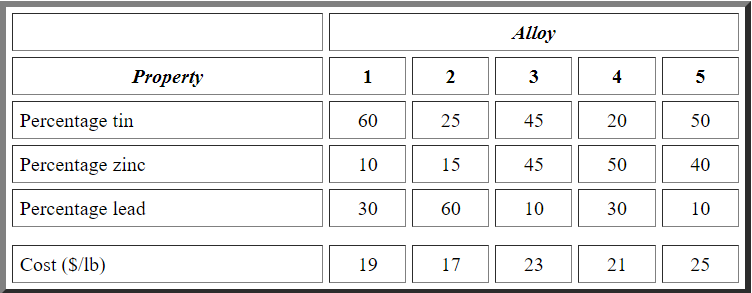

#### Formulation
$$
\begin{align*}
\text{Minimize}&\ 19x_1 + 17x_2 + 23x_3 + 21x_4 + 25x_5\\
\text{subject to}&\ x_1 + x_2 + x_3 + x_4 + x_5  = 1 \\
&\ 60x_1 + 25x_2 + 45x_3 + 20x_4 + 50x_5 = 40 \\
&\ 10x_1 + 15x_2 + 45x_3 + 50x_4 + 40x_5 = 35 \\
&\ 30x_1 + 60x_2 + 10x_3 + 30x_4 + 10x_5 = 25 \\
&\ x \geq 0
\end{align*}
$$
#### Solution
##### Using SimplexSolver

In [235]:
c = np.array([19,17,23,21,25])
A = np.array([[1,1,1,1,1],
              [60,25,45,20,50],
              [10,15,45,50,40],
              [30,60,10,30,10]])
b = np.array([1,40,35,25])
signs = np.array(["="]*4)
a = SimplexSolver(c,A,b,signs, verbose = True)
solution , value, direction = a.solve()

Solver object created with 5 variables and 4 constraints.
0 slack variables added.
Begin Phase 1 with 4 artificial variables.
Step Zero Phase 1 Tableau: 
[[ 0.  0.  0.  0.  0. -1. -1. -1. -1.  0.]
 [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
 [60. 25. 45. 20. 50.  0.  1.  0.  0. 40.]
 [10. 15. 45. 50. 40.  0.  0.  1.  0. 35.]
 [30. 60. 10. 30. 10.  0.  0.  0.  1. 25.]]
Basis Columns:
[5, 6, 7, 8]
Step 1 Phase 1 Tableau. Current RHS = 101.0
[[101. 101. 101. 101. 101.   0.   0.   0.   0. 101.]
 [  1.   1.   1.   1.   1.   1.   0.   0.   0.   1.]
 [ 60.  25.  45.  20.  50.   0.   1.   0.   0.  40.]
 [ 10.  15.  45.  50.  40.   0.   0.   1.   0.  35.]
 [ 30.  60.  10.  30.  10.   0.   0.   0.   1.  25.]]
Starting Phase 1:
--------------------------------------------------
Pivot Row= 2
Leaving Variable = 6, Entering Variable = 0
Basis: [5 0 7 8]
tableau: 
[[  0.    58.92  25.25  67.33  16.83   0.    -1.68   0.     0.    33.67]
 [  0.     0.58   0.25   0.67   0.17   1.    -0.02   0.     0.    

##### Using a Commercial Solver (CVXPY)

In [236]:
x = cp.Variable((5,1))
c = np.array([19,17,23,21,25])
c.shape = (1,5)
A = np.array([[1,1,1,1,1],
              [60,25,45,20,50],
              [10,15,45,50,40],
              [30,60,10,30,10]])
A.shape = (4,5)
b = np.array([1,40,35,25])
b.shape = (4,1)
constraints = [cp.matmul(A,x) == b, x >= 0]
objective = cp.Minimize(cp.matmul(c,x))
prob = cp.Problem(objective, constraints)
prob.solve()
solution= x.value
value = prob.value
print("The solution is: ", solution.T, " with an objective value of", value)

The solution is:  [[0.34375    0.         0.25       0.40625    0.00000001]]  with an objective value of 20.812500019620014


### Model 11: A Packing Problem
#### Description
A cargo plane has three compartments for storing cargo: front, center, and back. These compartments have capacity limits on both weight and space, as summarized below:

| Compartment | Weight Capacity (Tons) | Space Capacity (cu ft) |
|-------------|:----------------------:|:----------------------:|
| Front       | 12                     | 7000                   |
| Center      | 18                     | 9000                   |
| Back        | 10                     | 5000                   |

Furthermore, the weight of the cargo in the respective compartments must be the same proportion of that compartment's weight capacity to maintain the balance of the airplane.

The following four cargoes have been offered for shipment on an upcoming flight as space is available:

| Cargo | Weight Capacity (Tons) | Space Capacity (cu ft/ton) | Profit ($/ton) |
|-------|:----------------------:|:--------------------------:|:--------------:|
| 1     | 20                     | 500                        | 280            |
| 2     | 16                     | 700                        | 360            |
| 3     | 25                     | 600                        | 320            |
| 4     | 13                     | 400                        | 250            |

Any portion of these cargoes can be accepted. The object is to determine how much (if any) of each cargo should be accepted and how to distribute each among the compartments to maximize the total profit for the flight.

#### Formulation
$$
\begin{align*}
\text{Maximize}&\ 280(f_1 + c_1 + b_1) + 360(f_2+c_2+b_2) + 320(f_3+c_3+b_3)+250(f_4+c_4+b_4)\\
\text{subject to}&\ \sum_{i=1}^4 f_i \leq 12\\
&\ \sum_{i=1}^4 c_i \leq 18\\
&\ \sum_{i=1}^4 b_i \leq 10\\
&\ f_1 + c_1 + b_1 \leq 20 \\
&\ f_2 + c_2 + b_2 \leq 16 \\
&\ f_3 + c_3 + b_3 \leq 25 \\
&\ f_4 + c_4 + b_4 \leq 13 \\
&\ 500f_1 + 700f_2 +600f_3+400f_4 \leq 7000 \\
&\ 500c_1 + 700c_2 +600c_3+400c_4 \leq 9000 \\
&\ 500b_1 + 700b_2 +600b_3+400b_4 \leq 5000 \\
&\ f_i,\ c_i,\ b_i \geq 0\ i = 1,2,3,4
\end{align*}
$$
#### Solution
##### Using SimplexSolver

In [237]:
# f1,f2,f3,f4,c1,c2,c3,c4,b1,b2,b3,b4
c = np.array([280,360,320,250,280,360,320,250,280,360,320,250])
A = np.array([[1,1,1,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,1,1,1,0,0,0,0],
              [0,0,0,0,0,0,0,0,1,1,1,1],
              [1,0,0,0,1,0,0,0,1,0,0,0],
              [0,1,0,0,0,1,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0],
              [0,0,0,1,0,0,0,1,0,0,0,1],
              [500,700,600,400,0,0,0,0,0,0,0,0],
              [0,0,0,0,500,700,600,400,0,0,0,0],
              [0,0,0,0,0,0,0,0,500,700,600,400]])
b = np.array([12,18,10,20,16,25,13,7000,9000,5000])
signs = np.array(["<="]*10)
a = SimplexSolver(c,A,b,signs, verbose = True, maximize = True)
solution , value, direction = a.solve()

Solver object created with 12 variables and 10 constraints.
10 slack variables added.
Begin Phase 1 with 10 artificial variables.
Step Zero Phase 1 Tableau: 
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.   -1.
    -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.    0.]
 [   1.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.
     1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
     0.    0.    0.    0.    0.    0.    0.    0.   12.]
 [   0.    0.    0.    0.    1.    1.    1.    1.    0.    0.    0.    0.
     0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
     0.    0.    0.    0.    0.    0.    0.    0.   18.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    1.    1.
     0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     1.    0.    0.    0.    0.    0.    0.    0.   10.]
 [   1.    0.    0.   

##### Using a Commercial Solver (CVXPY)

In [238]:
x = cp.Variable((12,1))
c = np.array([280,360,320,250,280,360,320,250,280,360,320,250])
c.shape = (1,12)
A = np.array([[1,1,1,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,1,1,1,0,0,0,0],
              [0,0,0,0,0,0,0,0,1,1,1,1],
              [1,0,0,0,1,0,0,0,1,0,0,0],
              [0,1,0,0,0,1,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0],
              [0,0,0,1,0,0,0,1,0,0,0,1],
              [500,700,600,400,0,0,0,0,0,0,0,0],
              [0,0,0,0,500,700,600,400,0,0,0,0],
              [0,0,0,0,0,0,0,0,500,700,600,400]])
b = np.array([12,18,10,20,16,25,13,7000,9000,5000])
b.shape = (10,1)
objective = cp.Maximize(cp.matmul(c,x))
constraints = [cp.matmul(A,x) <= b, x>=0]
prob = cp.Problem(objective, constraints)
prob.solve()
solution= x.value
value = prob.value
print("The solution is: ", solution.T, " with an objective value of", value)

The solution is:  [[2.5886921  3.04563599 5.13719995 1.22847197 4.56318214 1.79472486
  4.02632167 7.61577132 2.6543766  0.96588854 2.22397887 4.15575601]]  with an objective value of 11730.000002083161
